In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr

from sklearn.metrics import accuracy_score

import logging

import sys
import os

from scipy.stats import binom_test
from mpl_toolkits.mplot3d import Axes3D
import math


In [59]:
class SuppressOutput:
    def __enter__(self):
        self.stdout = sys.stdout
        self.stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
        sys.stdout = self.devnull
        sys.stderr = self.devnull

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self.stdout
        sys.stderr = self.stderr


In [60]:
def filter_data(ticker_list, start, end):

    data_list = []

    for ticker in ticker_list:
        with SuppressOutput():
            data = yf.download(ticker, start=start, end=end)
        data_list.append(data)

    return dict(zip(ticker_list, data_list))
        

    

In [61]:
def create_data(ticker, ticker_name, l_wind, s_wind, wind):

    df = pd.DataFrame(ticker)
    date = df.index.tolist()
    df['Date'] = pd.to_datetime(date)

    df['Index'] = list(range(0, len(df['Date'])))

    large_window = l_wind
    small_window = s_wind
    window = wind

    # Calculate the moving average
    df['LMA'] = df['Open'].ewm(span=large_window, adjust=False).mean()
    df['SMA'] = df['Open'].ewm(span=small_window, adjust=False).mean()
    df['MA'] = df['Open'].ewm(span=window, adjust=False).mean()

    return df








In [62]:
def create_train_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict


def train_model(ticker_dict, large_window, short_window, window):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    lma = [lma for _, lma, _ in train_set]
    sma = [sma for _, _, sma in train_set]
    gain = [gain for gain, _, _ in train_set]

    # fig = plt.figure(figsize = (20, 8))
    # plt.scatter(lma, sma, c=gain, cmap='bwr', marker='o')

    # # Add color bar
    # cbar = plt.colorbar()
    # cbar.set_label('Binary Value')

    # plt.title("Scatter plot of winning (red) and losing (blue) trades based on rate of change in moving averages")
    # plt.xlabel("Long-term Moving Average")
    # plt.ylabel("Short-term Moving Average")

    # # Show the plot
    # plt.show()

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    # print("Valid crossovers:", len(target))
    # print("Successful crossovers:", target.count(1))

    model = RandomForestClassifier(n_estimators = 20, max_depth = 4)
    # model = LogisticRegression()
    model.fit(features, target)

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .7:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return model



In [63]:
def create_test_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict

def test_model(ticker_dict, large_window, short_window, window, model):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print("Predicted successful crossovers:", preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .85:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return (correct_signals / trades, target.count(1) / len(target))



In [64]:
window = 200
large_window = 80
small_window = 20


In [65]:


init_start = '2013-09-06'
init_end = '2023-09-14'

start_date = '2020-09-01'
end_date = '2023-09-14'

recent_start = '2022-08-01'
recent_end = '2023-09-14'

long_start = '2018-08-31'
long_end = '2023-09-14'

train_start = '2003-08-31'
train_end = '2013-09-14'

common_ticks = [
    "TSLA", "NIO", "AMD", "WBD", "NU", "TLRY", "NVDA", "AAPL", "PLTR", "INTC",
    "AMZN", "BAC", "F", "VALE", "WBA", "PARA", "XPEV", "DELL", "DNA", "DIS",
    "NUVA", "KVUE", "RIVN", "BEKE", "MARA", "GRAB", "GOOGL", "BKI", "LCID", "T",
    "HPE", "RIG", "AFRM", "CMCSA", "SWN", "SNAP", "OPEN", "SOFI", "PFE", "BABA",
    "HZNP", "CCL", "GOOG", "LYFT", "S", "MSFT", "XOM", "AAL", "VZ", "UBER", "KMI",
    "CSCO", "GSAT", "SHOP", "USB", "PDD", "META", "WFC", "C", "BBD", "CSX", "NOK",
    "GOLD", "JD", "LU", "PYPL", "IQ", "KEY", "KO", "PLUG", "FCX", "MU", "DG", "CVNA",
    "PCG", "RYCEY", "SIRI", "TAL", "BCS", "CHWY", "MRO", "IOT", "NTNX", "HPQ", "KGC",
    "XP", "HBAN", "YMM", "SCHW", "DVN", "RBLX", "DKNG", "HOOD", "LYG", "OXY", "ET",
    "GM", "M", "HAL", "JNJ", "OLN", "BKR", "NEE", "CVE", "ABCM", "DISH", "TFC",
    "JPM", "AGNC", "IONQ", "KHC", "RF", "MRVL", "MDLZ", "FOXA", "STLA", "ROKU",
    "TSM", "CVX", "NKE", "CVS", "SBUX", "CRM", "GPS", "INFY", "QCOM", "LULU", "FITB",
    "BMY", "UL", "PDD", "SPGI", "AMAT", "RY", "HON", "NOW", "GE", "RTX", "QCOM", "IDEXY",
    "FTI", "LUV", "VFS", "ROKU", "DISH", "USB", "SLB", "BUR", "GOLD", "RIG", "BKR", "DAL",
    "KHC", "CLF", "AGNC", "SNOW", "RUN", "GGB", "AEO", "CIG", "ENB", "RF", "NEE", "PTEN", "CVX"
    "VST", "VTRS", "BTE", "CARR", "BRFS", "CLVT", "CVE", "JPM", "PR", "KGC",
    "JNJ", "NYCB", "MDLZ", "MO", "MRK", "XPEV", "JCI", "HPE", "GILD", "TEVA",
    "D", "NEM", "EQT", "NKE", "IQ", "WU", "OXY", "BCS", "FCX", "ROL", "FHN", "HST", "U", "BTG", "CNHI", "MS",
    "WMB", "FITB", "AES", "RTX", "KIM", "CVNA", "HPQ", "X", "WRK", "FNMA", "TSM", "FTNT", "AMCR", "INFY"
    "BA", "BROS", "COIN", "CTRA", "FSR", "DELL", "DIDIY", "STLA", "CVS", "BK", "JD", "COTY",
    "KDP", "SBSW", "TME", "TOST", "PSNY", "ATVI", "NWL", "CHWY", "SE", "BEKE", "PPL", "NOV", "VFC", "ZI", "VLO"
    "SBRA", "DVN", "CNQ", "BB", "ADBE", "ORCL", "IBM", "CRM", "INTC", "CSCO", "AMD", "SAP",
    "QCOM", "AVGO", 'CVX', "HD", "LLY", "PG", "WMT", "LVMUY", "JPM", "XOM", "JNJ", "UNH", "BRK-A", "BRK-B",
    "GM", "MA", "NESN.SW", "MRK", "ABBV", "KO", "PEP", "COST", "SHEL", "MCD", "DIS", "NKE",
    "CAT", "LOW", "UNP", "GE"
]

common_ticks = list(set(common_ticks))


common_init = create_train_set(common_ticks, init_start, init_end, large_window, small_window, window)
common_mid = create_train_set(common_ticks, start_date, end_date, large_window, small_window, window)
common_short = create_train_set(common_ticks, recent_start, recent_end, large_window, small_window, window)
common_long = create_train_set(common_ticks, train_start, train_end, large_window, small_window, window)
common_decade = create_train_set(common_ticks, long_start, long_end, large_window, small_window, window)

In [66]:


def get_crossover_data(dataset, window):
    train_data = []
    for i in range(20, len(dataset) - 25):
        if dataset['SMA'][i - 6] <= dataset['LMA'][i - 6] and dataset['SMA'][i - 5] > dataset['LMA'][i - 5]:
            lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
            sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10
            ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
            if(lma_change > 0.002):
                future = list(dataset['High'][i+2:i+20])
                gain = 1 if any(value > dataset['Open'][i + 1] * 1.05 for value in future) else 0
                train_data.append((gain, lma_change, sma_change))
    return train_data

In [67]:

model = train_model(common_long, large_window, small_window, window)

Amount of trades 137
Amount of successful trades 126
Accuracy: 0.7521739130434782


In [68]:
test_model(common_init, large_window, small_window, window, model)

Valid crossovers: 536
Successful crossovers: 372
Predicted successful crossovers: 526
Amount of trades 122
Amount of successful trades 101
Accuracy: 0.6940298507462687


(0.8278688524590164, 0.6940298507462687)

Buy signal: EQT on 2020-04-16 00:00:00
EQT bought on 2020-04-17 00:00:00: 13.040
Sell signal: EQT on 2020-04-20 00:00:00
EQT sold on 2020-04-21 00:00:00: 15.740, move: 0.207
Buy signal: SHOP on 2020-04-23 00:00:00
Buy signal: BTG on 2020-04-23 00:00:00
SHOP bought on 2020-04-24 00:00:00: 62.400
Sell signal: SHOP on 2020-04-27 00:00:00
SHOP sold on 2020-04-28 00:00:00: 63.400, move: 0.016
Buy signal: CVNA on 2020-05-04 00:00:00
CVNA bought on 2020-05-05 00:00:00: 82.000
Sell signal: CVNA on 2020-05-05 00:00:00
CVNA sold on 2020-05-06 00:00:00: 86.500, move: 0.055
Buy signal: SNAP on 2020-05-06 00:00:00
SNAP bought on 2020-05-07 00:00:00: 17.600
Sell signal: SNAP on 2020-05-29 00:00:00
SNAP sold on 2020-06-01 00:00:00: 19.000, move: 0.080
Buy signal: DISH on 2020-06-05 00:00:00
DISH bought on 2020-06-08 00:00:00: 35.940
Buy signal: XP on 2020-06-09 00:00:00
XP bought on 2020-06-10 00:00:00: 40.680
Sell signal: XP on 2020-06-16 00:00:00
XP sold on 2020-06-17 00:00:00: 44.500, move: 0.094


1.8733452456661148

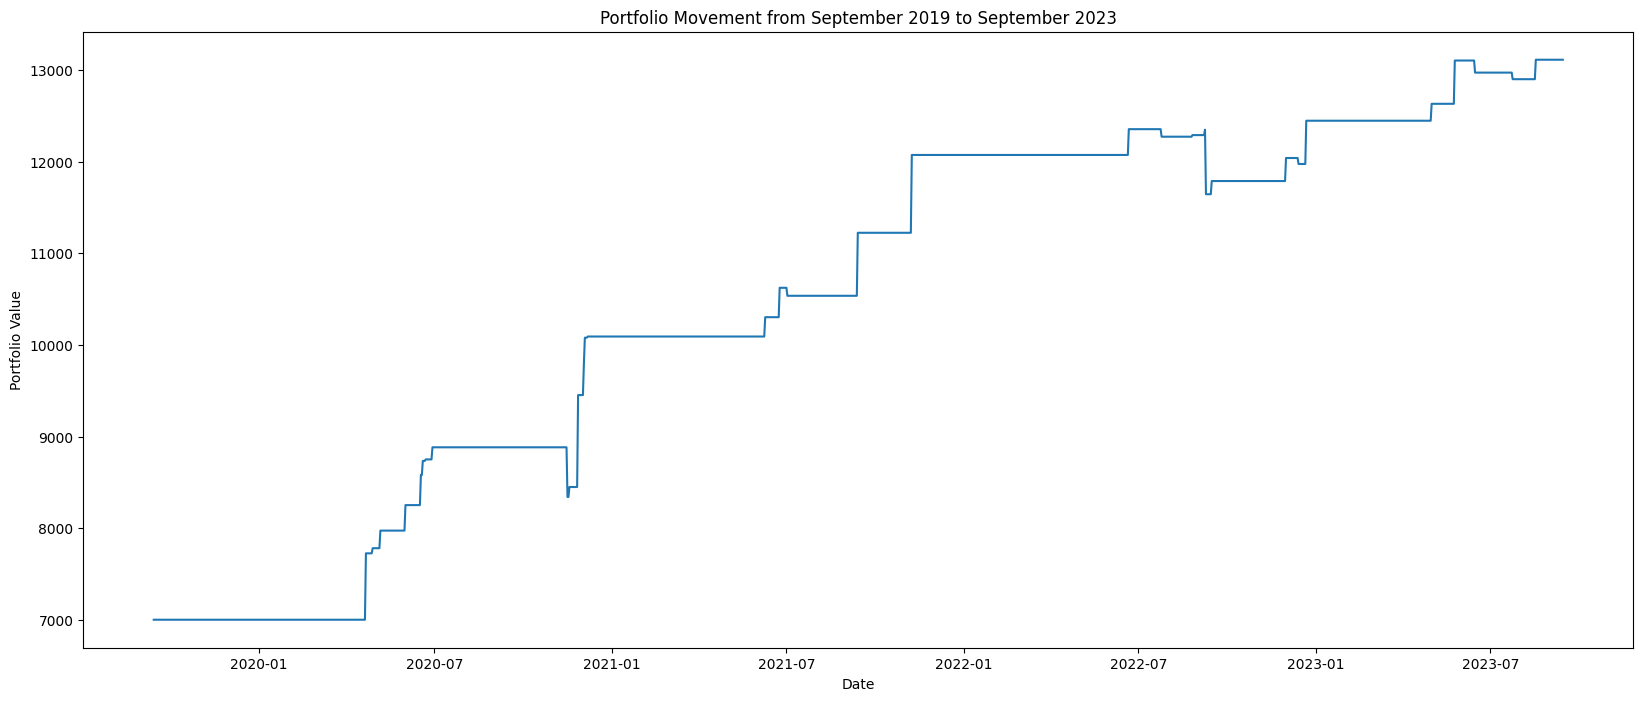

In [80]:

def get_signal_data(ticker_dict, window, model):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(20, len(dataset)):
            if dataset['SMA'][i - 6] <= dataset['LMA'][i - 6] and dataset['SMA'][i - 5] > dataset['LMA'][i - 5]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]

                if(lma_change > .002 and model.predict_proba(np.array([lma_change, sma_change]).reshape(1, -1))[0, 1] > .9):
                    date = dataset['Date'][i]
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    trade_data.append((date, ticker))
    return trade_data

def create_trade_signals(ticker_dict, window, initial_capital, trade_amount, model):
    capital = initial_capital
    trade_data = get_signal_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Ticker'])
    sorted_df = trade_df.sort_values(by='Date')
    sorted_df = sorted_df.reset_index(drop=True)

    date_range = pd.date_range(start= "2019-09-14", end= "2023-09-14")
    date_list = date_range.tolist()

    # positions = []

    wins = []
    loss = []


    to_buy = []
    positions = []
    to_sell = []

    loss = []
    wins = []

    dates = []
    portfolio = []

    buys = []

    for i in date_list:
        # Buy positions the next day

        for asset in to_buy:
            asset_df = ticker_dict[asset[0]]
            index = list(asset_df['Date']).index(asset[1])
            if(i == (asset_df['Date'][index + 1])):
                print("{} bought on {}: {:.3f}".format(asset[0], i, asset_df['Open'][index + 1]))
                capital -= trade_amount
                positions.append([asset[0], asset_df['Open'][index + 1], 20])
                to_buy.remove(asset)




        # Sell positions

        for asset in to_sell:
            asset_df = ticker_dict[asset[0][0]]
            if i == asset_df['Date'][asset[1]]:
                sell_price = asset_df['Open'][asset[1]]
                buy_price = asset[0][1]
                capital += trade_amount * (sell_price / buy_price)
                print("{} sold on {}: {:.3f}, move: {:.3f}".format(asset[0][0], i, sell_price, sell_price / buy_price - 1))
                to_sell.remove(asset)
                positions.remove(asset[0])
                move = sell_price / buy_price - 1
                if move < 0:
                    loss.append(move)
                if move > 0:
                    wins.append(move)
                


        # Mark position for selling

        for asset in positions:
            asset_df = ticker_dict[asset[0]]
            if i in asset_df['Date']:
                index = list(asset_df['Date']).index(i)
                asset[2]-= 1
                if asset_df['High'][index] > asset[1] * 1.05:
                    to_sell.append([asset, index + 1])
                    print("Sell signal: {} on {}".format(asset[0], i))
                elif asset[2] == 0:
                    to_sell.append([asset, index + 1])
                    print("Hold limit reached for {}".format(asset[0]))
                # elif asset_df['Low'][index] < asset[1] * .85:
                #     to_sell.append([asset, index + 1])
                #     print("Stop loss triggered for {}".format(asset[0]))
                






        # Create buy signal
        for n in range(len(sorted_df['Date'])):
            if sorted_df['Date'][n] == i:
                buys.append([sorted_df['Date'][n], sorted_df['Ticker'][n]])

            if sorted_df['Date'][n] == i and capital > trade_amount:
                # capital -= trade_amount
                print("Buy signal: {} on {}".format(sorted_df['Ticker'][n], sorted_df['Date'][n]))
                to_buy.append((sorted_df['Ticker'][n], sorted_df['Date'][n]))

                # positions.append([sorted_df['Buy'][n], sorted_df['Sell'][n], sorted_df['Sell_date'][n], sorted_df['Hold'][n], sorted_df['Ticker'][n]])

        portfolio.append((capital + len(positions) * trade_amount))
        dates.append(i)

    print((capital + len(positions) * trade_amount) / initial_capital)
    print(len(wins))
    print(len(loss))
    print(np.mean(wins))
    print(np.mean(loss))
    plt.figure(figsize = (20, 8))
    plt.plot(dates, portfolio)
    plt.title("Portfolio Movement from September 2019 to September 2023")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")

    for b in buys:
        print("{}: Buy signal for {}".format(b[0], b[1]))

    return (capital + len(positions) * trade_amount) / initial_capital

create_trade_signals(common_decade, window, 7000, 3500, model)

In [ ]:
mid = []
short = []

for i in range(10):
    
    short.append(create_trade_signals(common_decade, window, 7000, 3500, model))
    mid.append(create_trade_signals(common_decade, window, 7000, 3500, model))